In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import ParameterGrid

In [3]:
df=pd.read_csv( "data/donnees_preprocesse_pour_modelisation.csv", sep=",")

In [7]:
data=df.copy()

- On veut modéliser la hauteur moyenne des vagues hautes 1h à l'avance donc à T+1 pour St Nazaré
- On va enlever les données non nécessaires du data set les lag allant de 2 à 23 (pour éviter que ça soit redondant)
- Ajouter lag 1 pour la variable hauteur moyenne des vagues hautes pour les autres balises
- Pour avoir la variable cible il faut shifter cette dernière

In [ ]:
data.head()

In [ ]:
data.describe().T

### Modélisation

### J'ai enlevé hour month et season

In [10]:
# Trier les données par index temporel 
series_data = data.sort_index()

# Séparer les features et la target 
features = series_data.drop(columns=["target","hour","month"])
target = series_data["target"]

In [207]:
# Choix des métriques en faisant un GridSearch sur 3 fenêtres (voir plus bas)

In [208]:
# Séparation du jeu de test final
test_size = 5000  # Dernières observations réservées au test
test_start = len(series_data) - test_size

X_test, y_test = features.iloc[test_start:], target.iloc[test_start:]

# Vérification des tailles
print(f"Total observations: {len(series_data)}")
print(f"Training + Validation observations: {test_start}")
print(f"Test observations: {len(X_test)}")

# Sliding Window Training & Validation
window_size = 3000  
horizon = 500       
step_size = 2000    

mae_scores = []
rmse_scores = []

# 🔹 Correction de la borne supérieure 🔹
for start in range(0, test_start - window_size, step_size):  
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
    X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

    # Initialisation du modèle
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        random_state=42
    )

    # Entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Prédiction
    y_val_pred = model.predict(X_val)

    # Évaluation
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Moyenne des scores de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# 🔹 Dernier modèle entraîné utilisé pour le test final 🔹
y_test_pred = model.predict(X_test)

# Évaluation finale sur test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")

Total observations: 17520
Training + Validation observations: 12520
Test observations: 5000
Fenêtre 0 → 3500: MAE=0.0087, RMSE=0.0117
Fenêtre 2000 → 5500: MAE=0.0180, RMSE=0.0417
Fenêtre 4000 → 7500: MAE=0.1334, RMSE=0.3960
Fenêtre 6000 → 9500: MAE=0.0149, RMSE=0.0212
Fenêtre 8000 → 11500: MAE=0.0355, RMSE=0.0586

MAE moyen validation: 0.0421
RMSE moyen validation: 0.1059

🔹 Performance finale sur TEST 🔹
MAE Test: 0.0200
RMSE Test: 0.0367


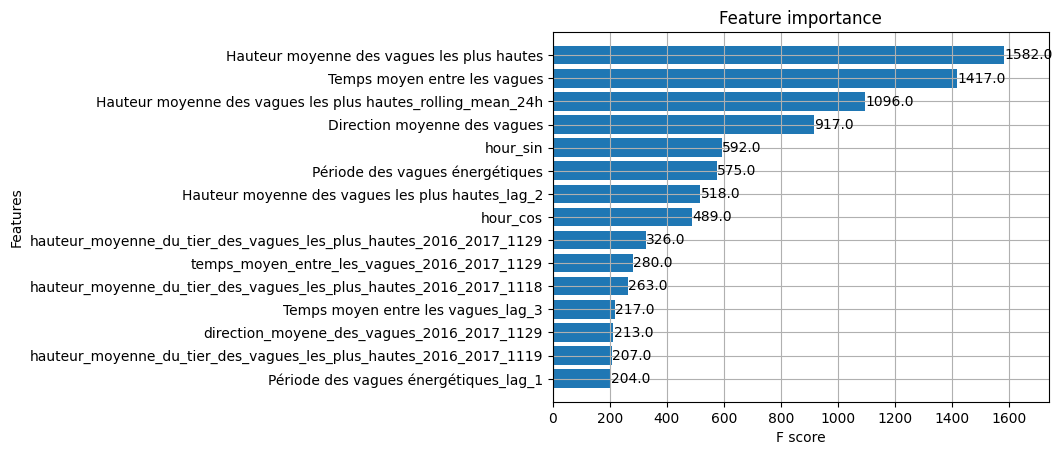

In [209]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

In [210]:
#Essayer de faire GridSearch sur 3 fênetres et garder 5000 obs pour test contre 2000 avant
#Essayer peut-être de garder 

In [211]:
test_size = 5000
test_start = len(series_data) - test_size

In [212]:
# 🔹 Définition des hyperparamètres à tester 🔹
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],
}

# 🔹 Paramètres du sliding window 🔹
window_size = 3000  
horizon = 500       
step_size = 2000    
num_windows = 3  # Nombre de fenêtres à utiliser pour le GridSearch

best_params = None
best_score = float("inf")  # On cherche à minimiser l'erreur

# 🔹 GridSearch sur plusieurs fenêtres 🔹
for params in ParameterGrid(param_grid):
    mae_scores = []

    for i, start in enumerate(range(0, test_start - window_size, step_size)):
        if i >= num_windows:  # Limite à num_windows fenêtres
            break
        
        train_start = start
        train_end = start + window_size
        val_end = train_end + horizon

        X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
        X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

        # Initialisation du modèle avec les hyperparamètres en test
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **params)

        # Entraînement
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

        # Prédiction
        y_val_pred = model.predict(X_val)

        # Évaluation
        mae = mean_absolute_error(y_val, y_val_pred)
        mae_scores.append(mae)

    # Moyenne des performances sur toutes les fenêtres
    avg_mae = np.mean(mae_scores)
    print(f"Params: {params} - MAE moyen: {avg_mae:.4f}")

    # Mise à jour des meilleurs paramètres
    if avg_mae < best_score:
        best_score = avg_mae
        best_params = params

print(f"\n✅ Meilleurs hyperparamètres après GridSearch: {best_params}")

# 🔹 Entraînement final sur toutes les fenêtres restantes 🔹
mae_scores = []
rmse_scores = []

for start in range(0, test_start - window_size, step_size):  
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
    X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

    # Initialisation du modèle avec les meilleurs hyperparamètres
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_params)

    # Entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Prédiction
    y_val_pred = model.predict(X_val)

    # Évaluation
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Moyenne des scores de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# 🔹 Dernier modèle entraîné utilisé pour le test final 🔹
y_test_pred = model.predict(X_test)

# Évaluation finale sur test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")


Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200} - MAE moyen: 0.1109
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300} - MAE moyen: 0.0727
Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400} - MAE moyen: 0.0594
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200} - MAE moyen: 0.1108
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300} - MAE moyen: 0.0726
Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 400} - MAE moyen: 0.0593
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} - MAE moyen: 0.0539
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300} - MAE moyen: 0.0539
Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400} - MAE moyen: 0.0538
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200} - MAE moyen: 0.0534
Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300} - MAE moyen: 0.0534
Params: {'learning_rate': 

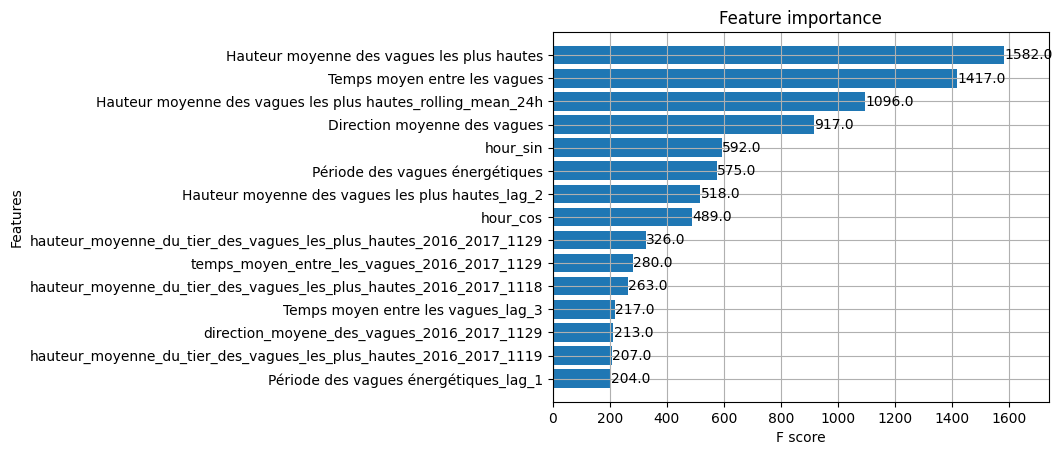

In [213]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

In [214]:
print("Distribution des valeurs dans l'entraînement :")
print(target.iloc[:test_start].describe())

print("\nDistribution des valeurs dans le test :")
print(target.iloc[test_start:].describe())


Distribution des valeurs dans l'entraînement :
count    12520.000000
mean         1.414167
std          0.690691
min          0.370880
25%          0.940496
50%          1.211034
75%          1.763632
max          4.445147
Name: target, dtype: float64

Distribution des valeurs dans le test :
count    5000.000000
mean        1.061877
std         0.481628
min         0.326232
25%         0.723583
50%         0.963991
75%         1.218108
max         4.149109
Name: target, dtype: float64


### Ajout du Benchmark

In [215]:
y_pred_benchmark = features["Hauteur moyenne des vagues les plus hautes_rolling_mean_24h"].loc[y_test.index]  # Prendre la valeur du benchmark sur la période de test

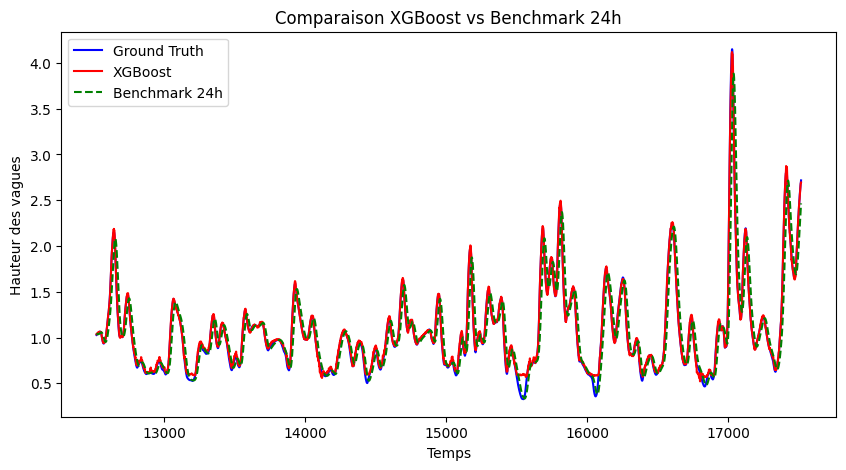

In [216]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Ground Truth', color='blue')
plt.plot(y_test.index, y_test_pred, label='XGBoost', color='red')
plt.plot(y_test.index, y_pred_benchmark, label='Benchmark 24h', color='green', linestyle="dashed")

plt.xlabel('Temps')
plt.ylabel('Hauteur des vagues')
plt.title('Comparaison XGBoost vs Benchmark 24h')
plt.legend()
plt.show()


In [217]:
# 📌 Calcul des performances du benchmark
mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_pred_benchmark))

# 📌 Affichage des performances
print(f"📌 XGBoost: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}")
print(f"📌 Benchmark 24h: MAE = {mae_benchmark:.4f}, RMSE = {rmse_benchmark:.4f}")

📌 XGBoost: MAE = 0.0200, RMSE = 0.0367
📌 Benchmark 24h: MAE = 0.1328, RMSE = 0.2045


T+2

In [218]:
# Création de la cible (T+2)
data['target_2'] = data['target'].shift(-1)
# En raison du shift, il n'y aura pas de T+2 pour la dernière observation (on l'a supprime donc)
data = data.dropna(subset=['target_2'])

In [219]:
print(data[['Hauteur moyenne des vagues les plus hautes','target', 'target_2']].head(10))
# pour voir si le décalage ets bon et me semble que oui

   Hauteur moyenne des vagues les plus hautes    target  target_2
0                                    3.490737  3.501528  3.509845
1                                    3.501528  3.509845  3.515597
2                                    3.509845  3.515597  3.519368
3                                    3.515597  3.519368  3.521430
4                                    3.519368  3.521430  3.515879
5                                    3.521430  3.515879  3.501259
6                                    3.515879  3.501259  3.481247
7                                    3.501259  3.481247  3.455081
8                                    3.481247  3.455081  3.417871
9                                    3.455081  3.417871  3.370244


In [226]:
# Trier les données par index temporel 
series_data = data.sort_index()

# Séparer les features et la target 
features = series_data.drop(columns=["target","target_2","hour","month"])
target = series_data["target_2"]

Faut-il supprimer le t-3 dans ce cas pour  Hauteur moyenne des vagues les plus hautes 

In [227]:
# Séparation du jeu de test final
test_size = 5000  # Dernières observations réservées au test
test_start = len(series_data) - test_size

X_test, y_test = features.iloc[test_start:], target.iloc[test_start:]

# Vérification des tailles
print(f"Total observations: {len(series_data)}")
print(f"Training + Validation observations: {test_start}")
print(f"Test observations: {len(X_test)}")

# Sliding Window Training & Validation
window_size = 3000  
horizon = 500       
step_size = 2000    

mae_scores = []
rmse_scores = []

# 🔹 Correction de la borne supérieure 🔹
for start in range(0, test_start - window_size, step_size):  
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    X_train, y_train = features.iloc[train_start:train_end], target.iloc[train_start:train_end]
    X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]

    # Initialisation du modèle
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        random_state=42
    )

    # Entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Prédiction
    y_val_pred = model.predict(X_val)

    # Évaluation
    mae = mean_absolute_error(y_val, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Moyenne des scores de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# 🔹 Dernier modèle entraîné utilisé pour le test final 🔹
y_test_pred = model.predict(X_test)

# Évaluation finale sur test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")

Total observations: 17519
Training + Validation observations: 12519
Test observations: 5000
Fenêtre 0 → 3500: MAE=0.0177, RMSE=0.0247
Fenêtre 2000 → 5500: MAE=0.0225, RMSE=0.0440
Fenêtre 4000 → 7500: MAE=0.1450, RMSE=0.4045
Fenêtre 6000 → 9500: MAE=0.0264, RMSE=0.0342
Fenêtre 8000 → 11500: MAE=0.0646, RMSE=0.0872

MAE moyen validation: 0.0552
RMSE moyen validation: 0.1189

🔹 Performance finale sur TEST 🔹
MAE Test: 0.0405
RMSE Test: 0.0604


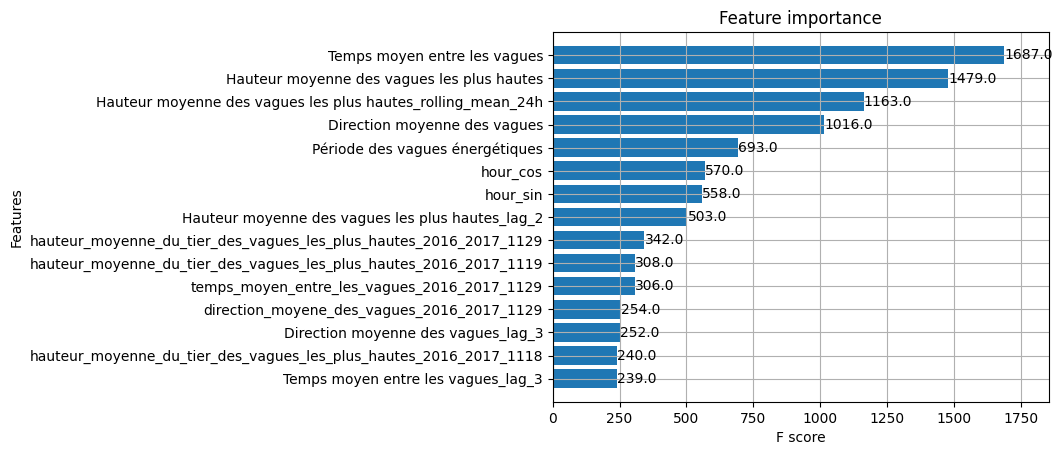

In [228]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

In [229]:
y_pred_benchmark = features["Hauteur moyenne des vagues les plus hautes_rolling_mean_24h"].loc[y_test.index]  # Prendre la valeur du benchmark sur la période de test


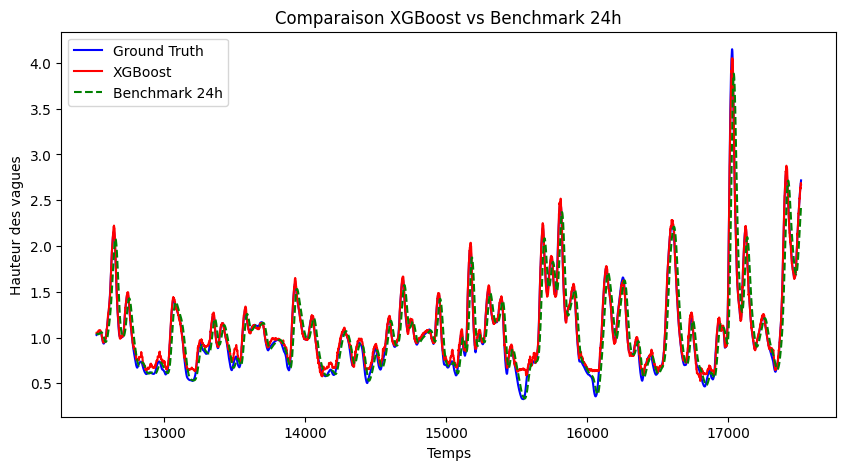

In [230]:
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Ground Truth', color='blue')
plt.plot(y_test.index, y_test_pred, label='XGBoost', color='red')
plt.plot(y_test.index, y_pred_benchmark, label='Benchmark 24h', color='green', linestyle="dashed")

plt.xlabel('Temps')
plt.ylabel('Hauteur des vagues')
plt.title('Comparaison XGBoost vs Benchmark 24h')
plt.legend()
plt.show()


In [231]:
# 📌 Calcul des performances du benchmark
mae_benchmark = mean_absolute_error(y_test, y_pred_benchmark)
rmse_benchmark = np.sqrt(mean_squared_error(y_test, y_pred_benchmark))

# 📌 Affichage des performances
print(f"📌 XGBoost: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}")
print(f"📌 Benchmark 24h: MAE = {mae_benchmark:.4f}, RMSE = {rmse_benchmark:.4f}")

📌 XGBoost: MAE = 0.0405, RMSE = 0.0604
📌 Benchmark 24h: MAE = 0.1425, RMSE = 0.2193


LSTM

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i : i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

# Trier les données par index temporel
series_data = data.sort_index()

# Normalisation des features avec StandardScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Séparation jeu de test final
test_size = 5000
test_start = len(series_data) - test_size
X_test, y_test = features_scaled[test_start:], target.iloc[test_start:].values

# Paramètres sliding window
window_size = 3000  # Longueur de la séquence d'entraînement
horizon = 500      # Longueur de validation
step_size = 1000   # Pas de glissement réduit pour plus de chevauchement
seq_length = 24    # Augmenté pour capturer plus de patterns temporels

mae_scores = []
rmse_scores = []

# Boucle de sliding window
for start in range(0, test_start - window_size, step_size):
    train_start = start
    train_end = start + window_size
    val_end = train_end + horizon
    
    # Découpage des données
    X_train = features_scaled[train_start:train_end]
    y_train = target.iloc[train_start:train_end].values
    X_val = features_scaled[train_end:val_end]
    y_val = target.iloc[train_end:val_end].values
    
    # Création des séquences
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    
    # Modèle LSTM amélioré
    model = Sequential([
        Input(shape=(seq_length, X_train.shape[1])),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    
    # Entraînement
    model.fit(
        X_train_seq, 
        y_train_seq,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_seq, y_val_seq),
        verbose=1
    )
    
    # Prédiction et évaluation
    y_val_pred = model.predict(X_val_seq, verbose=0)
    mae = mean_absolute_error(y_val_seq, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    print(f"Fenêtre {start} → {val_end}: MAE={mae:.4f}, RMSE={rmse:.4f}")

# Affichage des scores moyens de validation
print(f"\nMAE moyen validation: {np.mean(mae_scores):.4f}")
print(f"RMSE moyen validation: {np.mean(rmse_scores):.4f}")

# Test final
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)
y_test_pred = model.predict(X_test_seq, verbose=0)
mae_test = mean_absolute_error(y_test_seq, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))

print(f"\n🔹 Performance finale sur TEST 🔹")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 1.4844 - val_loss: 0.1059
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1250 - val_loss: 0.0152
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0681 - val_loss: 0.0460
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0535 - val_loss: 0.0167
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0568 - val_loss: 0.0116
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0432 - val_loss: 0.0303
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0420 - val_loss: 0.0108
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0445 - val_loss: 0.0081
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0337 - val_loss: 0.0182
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0321 - val_loss: 0.0116
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0358 - val_loss: 0.0099
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0